# Hyperparameter tuning on gender classification in facial images: <br> Batch sizes and Learning rates

Here, the hyperparameters such as the optimal learning rate and the batch size are found through a grid search by looping STL-based VGG models covering all combinations specified learning rates and batch sizes for gender classification. Each model is trained and validated on 15% of data and run for 10 epochs.

Learning rates used:  [1x10$^{-6}$, 1x10$^{-5}$, 1x10$^{-4}$, 1x10$^{-3}$, 1x10$^{-2}$] <br>
Batch sizes used: [16, 32, 64, 128, 256]

Model architecture used:  VGG16 base (frozen except block 5) + [128 nodes] + [2 output nodes]. <br>The ImageNet weights are used to initialize the VGG16 convolutional base.

Conclusion:  <br>
Best batch size = 32 <br>
Best learning rate = 0.0001 <br>
The learning rate 0.0001 seems to produce comparable validation accuracies within 0.88 to 0.90 range for varing batch sizes of 16, 32, 64, 128 and 256.

The following shows the required imports to run this colab file.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import set_random_seed
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras.callbacks import Callback

Now, the seed is set to a random integer so that same sequence of random numbers are generated each time the programme is run. Therefore, this ensures that the results are reproducible.

In [ ]:
# Setting the seed
seed = 42
set_random_seed(seed)
np.random.seed(42)

Here, my Google Drive is connected to this Colab file.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Below folder contains the cropped faces of the UTKFace data (Song, Zhang and Qi, 2017) from the "RetinaFace" algorithm (Deng et al., 2020). This deep learning based algorithm was used to extract faces with a fixed spatial resolution of 100 x 100 and save them in RGB image form.

In [ ]:
folder_path = "/content/drive/My Drive/UTKFace_retina_cropped_100x100"

Following shows the total number of facial images stored in the folder.

In [ ]:
cnt = 0
for file in sorted(os.listdir(folder_path)):  # Sort file list
  file_path = os.path.join(folder_path,file)
  cnt = cnt + 1

print(f"Number of face images: {cnt}")

Number of face images: 23561


The following code creates a bar chart showing the gender counts in the UTKFace dataset used in this study.

Text(0.5, 1.0, 'Distribution of gender in the UTKFace dataset')

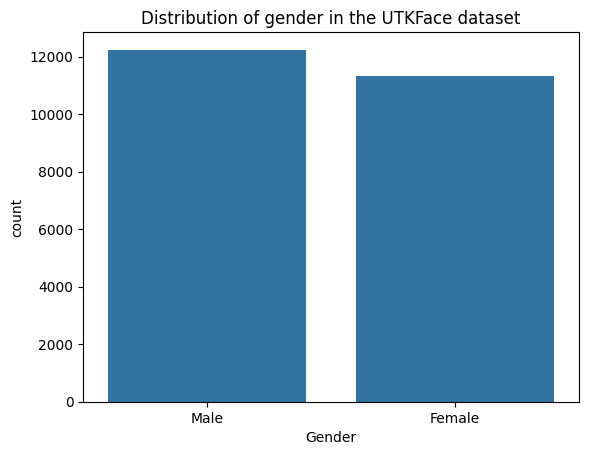

In [ ]:
# age: is an integer from 0 to 116, indicating the age
# gender: is either 0 (male) or 1 (female)
# race: is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

column_names = ['Age', 'Gender', 'Race']
records = []

for file in os.listdir(folder_path):
  records.append(file.split('_')[:-1])

DFrame=pd.DataFrame(records, columns=column_names).astype(int)

gender_mapping = {
    0: 'Male',
    1: 'Female'
}

# Replace the integers with correct gender
DFrame['Gender'] = DFrame['Gender'].replace(gender_mapping)

# Count plot
plt.figure()
sns.countplot(x='Gender', data=DFrame)
plt.title('Distribution of gender in the UTKFace dataset')

In [ ]:
def read_image(fname):
    # Extracting label from file name
    parts = tf.strings.split(fname, os.sep)
    file_name = parts[-1]
    multiple_labels = tf.strings.split(file_name, '_')

    # Extracting labels
    gender_label = tf.strings.to_number(multiple_labels[1], out_type=tf.int32)     # Second part: gender

    # Loading and decoding the image
    image = tf.io.read_file(fname)
    image = tf.io.decode_jpeg(image)
    return image, gender_label

In [ ]:
def preprocess_image(image, gender_label):
    # Converting image to float32 and normalize to [0,1]
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, gender_label

This below code splits a dataset of file paths into 10% for training and 5% for validation using TensorFlow's tf.data.Dataset API. It starts by listing all files in a specified folder and shuffling them for randomness with a fixed seed for reproducibility. The dataset is then divided according to the above mentioned percentages.

In [ ]:
# Creating training, validation and test sets.
list_ds = tf.data.Dataset.list_files(folder_path + "/*")

# Total number of files
file_count = len(list_ds)

# Defining split sizes
train_size = int(0.1 * file_count)  # 10% for training
val_size = int(0.05 * file_count)    # 5% for validation

# Shuffling the dataset before splitting
list_ds = list_ds.shuffle(buffer_size=file_count, seed=42)

# Splitting into training, validation, and test datasets
train_list_ds = list_ds.take(train_size)  # First 10% for training
val_list_ds = list_ds.skip(train_size).take(val_size)  # Next 5% for validation

## 2. Building a CNN using Transfer Learning on VGG16
Input image shape: (100, 100, 3)

The following code tunes hyperparameters for gender classification. It begins by creating a convolutional neural network (CNN) based on a modified VGG16 architecture. This model has a VGG16 convolutional base with five blocks, each containing multiple convolutional layers followed by max-pooling to progressively extract spatial features while reducing dimensionality. Pre-trained weights from ImageNet are loaded into this base model to leverage learned representations. All layers in the base model are frozen to preserve these pre-trained features except the 5th block. Then a fully connected layer (FC1) with 128 nodes is attached along with an output layer with 2 nodes.

The training and validation datasets are created and batched according each batch size listed. Each dataset is prepared by mapping file paths to images using read_image, followed by applying preprocessing with preprocess_image. Then, the datasets are batched according to each size, cached for faster reuse, and prefetched to improve performance by preparing the next batch while the current one is being processed. The use of tf.data.AUTOTUNE optimizes parallelism and performance. Then  for each batch size and for each learning rate specified in the list, the model is trained.

In [ ]:
from tensorflow.keras.applications import vgg16

gender_loss = []
gender_val_loss = []
gender_accuracy = []
gender_val_accuracy = []
evaluation_results = []
batch_sizes = [16, 32, 64, 128, 256]
learning_rates = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
para_combinations = []

# Load the vgg16 model with pre-trained ImageNet weights and without the top classification layer
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

no = 0
for batch_size in batch_sizes:
  # Dataset preparation with preprocessing
  train_ds = (
      train_list_ds
      .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
      .map(lambda img, gender_lbl:
          preprocess_image(img, gender_lbl),  # Applying preprocessing
          num_parallel_calls=tf.data.AUTOTUNE)
      .batch(batch_size)
      .cache()
      .prefetch(tf.data.AUTOTUNE)
      )

  val_ds = (
      val_list_ds
      .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
      .map(lambda img, gender_lbl:
          preprocess_image(img, gender_lbl),  # Applying preprocessing
          num_parallel_calls=tf.data.AUTOTUNE)
      .batch(batch_size)
      .cache()
      .prefetch(tf.data.AUTOTUNE)
      )

  # Preloading datasets by iterating through them once
  print(f"Preloading training dataset with batch_size = {batch_size}...")
  for _ in train_ds:
    pass  # This ensures the entire training dataset is cached
  print(f"Preloading validation dataset with batch_size = {batch_size}...")
  for _ in val_ds:
    pass  # This ensures the entire validation dataset is cached
  print("Datasets preloaded successfully!")

  for lr in learning_rates:
    seed = 42
    set_random_seed(seed)
    np.random.seed(42)

    img_input = layers.Input((100, 100, 3), dtype='float32', name='base_model')

    # Clone the base model
    cl_base = models.clone_model(base_model)
    cl_base.set_weights(base_model.get_weights())

    for layer in cl_base.layers[:15]:
      layer.trainable = False

    # Gender Classification
    gender_vec = layers.GlobalAveragePooling2D()(cl_base.output)
    gender = layers.Dense(128, activation='relu', name='gender_fc1')(gender_vec)
    gender_out = layers.Dense(2, activation='softmax', name='gender_output')(gender)

    # Single-task Model
    model = models.Model(inputs=cl_base.input, outputs=[gender_out], name='st_model')

    # Creating the checkpoint callback
    checkpoint_path = '/content/checkpoint/weights.keras'
    mc_callback = ModelCheckpoint(filepath=checkpoint_path,
                                monitor='val_accuracy',
                                save_best_only=True,
                                mode='max')

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

    print(f"Training a VGG model with FC1 = 128, batch_size = {batch_size} and learning_rate = {lr}")
    history = model.fit(
                      train_ds,
                      epochs=10,
                      validation_data=val_ds,
                      batch_size=batch_size,
                      callbacks=[mc_callback]
                     )
    # My model’s last layer has a softmax activation, thus from_logits=False

    gender_loss.append(history.history['loss'])
    gender_val_loss.append(history.history['val_loss'])
    gender_accuracy.append(history.history['accuracy'])
    gender_val_accuracy.append(history.history['val_accuracy'])
    para_combinations.append(f'model_{no}_lr_{lr}_batchSize_{batch_size}')
    no = no + 1
    # Loading the weights of the model with the best validation accuracy
    model.load_weights(checkpoint_path)

    # Evaluating the model on the test dataset
    evaluation_results.append(model.evaluate(val_ds, verbose=2))

Preloading training dataset with batch_size = 16...
Preloading validation dataset with batch_size = 16...
Datasets preloaded successfully!
Training a VGG model with FC1 = 128, batch_size = 16 and learning_rate = 1e-06
Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.4954 - loss: 0.7337 - val_accuracy: 0.6570 - val_loss: 0.6545
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.6894 - loss: 0.6345 - val_accuracy: 0.7360 - val_loss: 0.5947
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.7684 - loss: 0.5697 - val_accuracy: 0.7776 - val_loss: 0.5330
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7955 - loss: 0.5064 - val_accuracy: 0.7886 - val_loss: 0.4816
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8044 - loss: 0.4575 - val_accuracy: 0.7971 - val_loss: 0.4488
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8123 - loss: 0.4255 - val_accuracy: 0.8039 - val_loss: 0.4278
Epoch 

In [ ]:
# best model
val_acc= np.max(np.array(gender_val_accuracy), axis=1)
ind, val = np.argmax(val_acc), np.max(val_acc)
print(f"model_id = {ind}, Best val_accuracy = {val}")
print(f"para_combinations = {para_combinations[ind]}")


model_id = 7, Best val_accuracy = 0.9023768901824951
para_combinations = model_7_lr_0.0001_batchSize_32


Displaying the validation accuracies for models in the grid search

In [ ]:
batch_sizes = [16, 32, 64, 128, 256]
learning_rates = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
val_acc = val_acc.reshape(5,5)

dframe1 = pd.DataFrame(val_acc)
dframe1.columns = ['1e-6', '1e-5', '1e-4', '1e-3', '1e-2']
dframe1.index = [16, 32, 64, 128, 256]
dframe1

,1e-6,1e-5,1e-4,1e-3,1e-2
16,0.834465,0.870968,0.891341,0.893039,0.854839
32,0.833616,0.887946,0.902377,0.896435,0.888795
64,0.775042,0.858234,0.874363,0.869270,0.832767
128,0.730900,0.851443,0.887097,0.884550,0.507640
256,0.658744,0.838710,0.882852,0.843803,0.725806


Plotting learning rate, batch size and validation accuracy - A 3D view

In [ ]:
import plotly.graph_objects as go

# Define parameters
batch_sizes = [16, 32, 64, 128, 256]
learning_rates = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

# Create the meshgrid
batch_sizes_grid, learning_rates_grid = np.meshgrid(batch_sizes, learning_rates)
val_acc = np.transpose(val_acc)

# Reshape val_acc to match the grid
val_acc_grid = val_acc.reshape(len(learning_rates), len(batch_sizes))

# Find the maximum value and its indices
max_val = np.max(val_acc)
max_idx = np.unravel_index(np.argmax(val_acc), val_acc_grid.shape)
max_batch_size = batch_sizes_grid[max_idx]
max_learning_rate = learning_rates_grid[max_idx]

# Create a Plotly Surface plot
fig = go.Figure(data=[
    go.Surface(
        z=val_acc_grid,
        x=batch_sizes_grid,
        y=learning_rates_grid,
        colorscale='Viridis',
        colorbar=dict(title='Validation Accuracy')
    ),
    # Add a Scatter3d point for the maximum value
    go.Scatter3d(
        x=[max_batch_size],
        y=[max_learning_rate],
        z=[max_val],
        mode='markers+text',
        marker=dict(size=10, color='red'),
        text=[f'Max: {max_val:.2f}, lr: {max_learning_rate}, batch_size={max_batch_size}'],
        textposition='top center'
    )
])

# Update layout for better readability
fig.update_layout(
    title='Validation Accuracy 3D Surface Plot with Maximum Value',
    scene=dict(
        xaxis_title='Batch Size',
        yaxis_title='Learning Rate',
        zaxis_title='Validation Accuracy',
        #xaxis=dict(type='log'),
        yaxis=dict(type='log')
    ),
    width=800,
    height=700
)

# Show the plot
fig.show()


Visualising training and validation losses and accuracies for the best learning rate

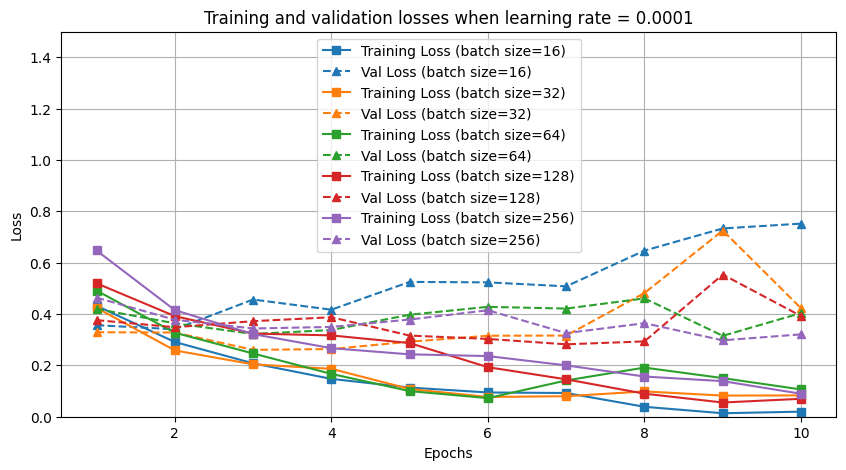

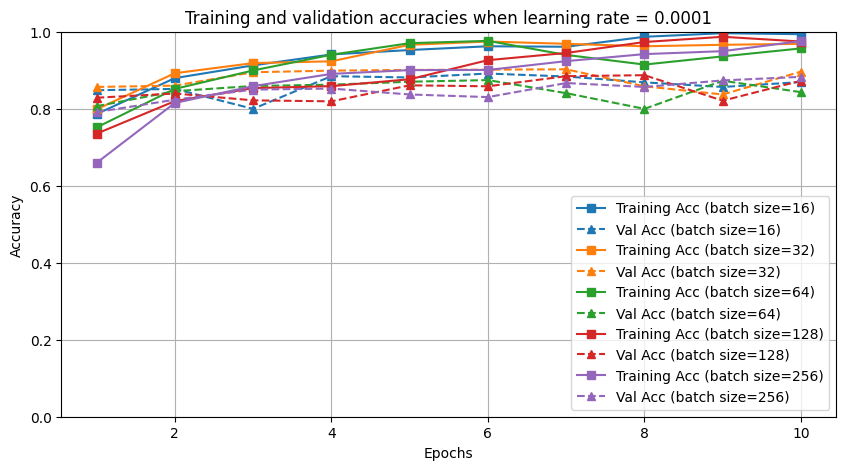

In [ ]:
# batch_sizes values
batch_sizes = [16,  32,  64,  128, 256]
lr_index = [2, 7, 12, 17, 22]   # of lr = 0.0001

Epochs = np.arange(1,11)

colours = plt.cm.tab10(range(len(batch_sizes)))   #colormap

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
for i, bsize in enumerate(batch_sizes):
  plt.plot(Epochs, gender_loss[lr_index[i]], color=colours[i],
           marker='s', label=f'Training Loss (batch size={bsize})')
  plt.plot(Epochs, gender_val_loss[lr_index[i]], color=colours[i],
           marker='^', linestyle='--', label=f'Val Loss (batch size={bsize})')

plt.title('Training and validation losses when learning rate = 0.0001')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0,1.5))
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
for i, bsize in enumerate(batch_sizes):
  plt.plot(Epochs, gender_accuracy[lr_index[i]], color=colours[i],
           marker = 's', label=f'Training Acc (batch size={bsize})')
  plt.plot(Epochs, gender_val_accuracy[lr_index[i]], color=colours[i],
           marker= '^', linestyle='--', label=f'Val Acc (batch size={bsize})')

plt.title('Training and validation accuracies when learning rate = 0.0001')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.legend(loc='lower right')
plt.grid()
plt.show()

